In [126]:
import numpy as np #array
import pandas as pd #data set
import yfinance as yf #api table
import matplotlib.pyplot as plt #graph visualization

import torch
import torch.nn as nn #build
import torch.optim as optim #train

from sklearn.preprocessing import StandardScaler #scale
from sklearn.metrics import root_mean_squared_error #evaluate

In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [128]:
ticker = 'APLD'
df = yf.download(ticker, '2023-08-01')

C:\Users\ptul0\AppData\Local\Temp\ipykernel_22748\3212347391.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2023-08-01')
[*********************100%***********************]  1 of 1 completed


In [129]:
df #table Close High Low Open Volume

Price,Close,High,Low,Open,Volume
Ticker,APLD,APLD,APLD,APLD,APLD
Date,,,,,
2023-08-01,9.260,9.40,8.7600,9.4000,4068100
2023-08-02,8.390,9.08,8.3250,8.8200,3256800
2023-08-03,8.010,8.49,8.0000,8.3400,3565800
2023-08-04,7.790,8.10,7.7100,8.0000,3448800
2023-08-07,7.900,7.99,7.5400,7.7900,2433900
...,...,...,...,...,...
2025-08-06,14.790,15.20,14.1000,14.8250,32663600
2025-08-07,14.240,15.36,13.6500,14.9800,28969200


<Axes: xlabel='Date'>

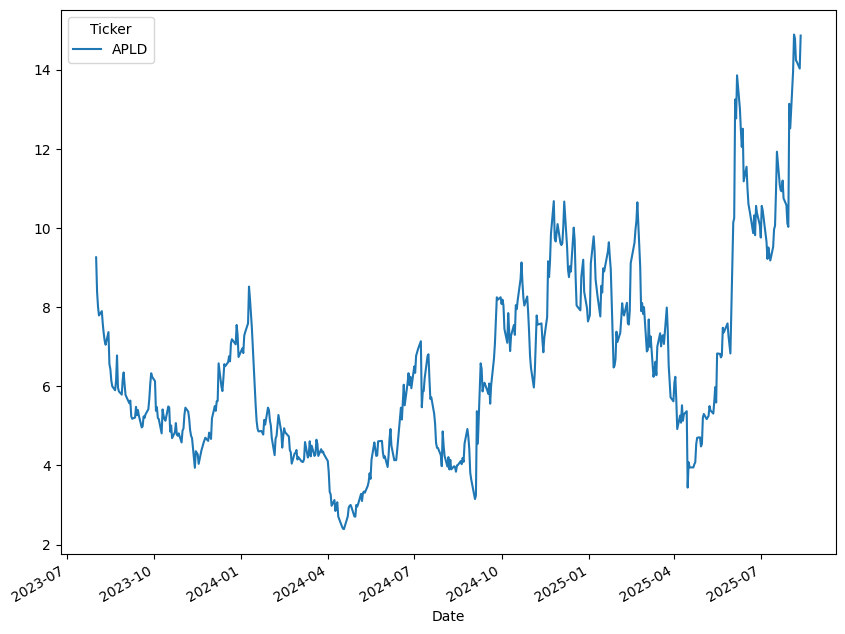

In [130]:
df.Close.plot(figsize=(10,8))

In [131]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [132]:
df.Close #table standard deviation of 1, mean of 0

Ticker,APLD
Date,
2023-08-01,1.156307
2023-08-02,0.795618
2023-08-03,0.638075
2023-08-04,0.546866
2023-08-07,0.592471
...,...
2025-08-06,3.448964
2025-08-07,3.220942
2025-08-08,3.204358


In [133]:
#LSTM = Long Short-Term Memory [Recurrent Neural Network]
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length]) #sequence-based machine learning model 1+2=3 >2+3=4 >3+4=5

data = np.array(data)

In [134]:
data 

array([[[ 1.15630696],
        [ 0.79561779],
        [ 0.63807533],
        ...,
        [-0.53520126],
        [-0.52276361],
        [-0.41082559]],

       [[ 0.79561779],
        [ 0.63807533],
        [ 0.54686645],
        ...,
        [-0.52276361],
        [-0.41082559],
        [-0.49788852]],

       [[ 0.63807533],
        [ 0.54686645],
        [ 0.59247089],
        ...,
        [-0.41082559],
        [-0.49788852],
        [-0.44399238]],

       ...,

       [[ 1.69526794],
        [ 1.62064246],
        [ 1.49212084],
        ...,
        [ 3.49042229],
        [ 3.4489636 ],
        [ 3.2209416 ]],

       [[ 1.62064246],
        [ 1.49212084],
        [ 1.36359962],
        ...,
        [ 3.4489636 ],
        [ 3.2209416 ],
        [ 3.20435821]],

       [[ 1.49212084],
        [ 1.36359962],
        [ 1.69526794],
        ...,
        [ 3.2209416 ],
        [ 3.20435821],
        [ 3.13387867]]], shape=(480, 30, 1))

In [ ]:
#train data

train_size= int(0.8 * len(data))

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device) #last seq

x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [ ]:
x_train 

tensor([[[ 1.1563],
         [ 0.7956],
         [ 0.6381],
         ...,
         [-0.5103],
         [-0.5352],
         [-0.5228]],

        [[ 0.7956],
         [ 0.6381],
         [ 0.5469],
         ...,
         [-0.5352],
         [-0.5228],
         [-0.4108]],

        [[ 0.6381],
         [ 0.5469],
         [ 0.5925],
         ...,
         [-0.5228],
         [-0.4108],
         [-0.4979]],

        ...,

        [[ 0.5842],
         [ 0.5469],
         [ 0.6795],
         ...,
         [ 0.3603],
         [ 0.2235],
         [ 0.3271]],

        [[ 0.5469],
         [ 0.6795],
         [ 0.4639],
         ...,
         [ 0.2235],
         [ 0.3271],
         [ 0.3396]],

        [[ 0.6795],
         [ 0.4639],
         [ 0.4515],
         ...,
         [ 0.3271],
         [ 0.3396],
         [ 0.2484]]])

In [ ]:
#architect LSTM layers

class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) #dropout=0.2
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [138]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [139]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#prediction error

num_epochs = 200
for i in range(num_epochs):
    y_train_pred = model(x_train) #prediction of price

    loss = criterion(y_train_pred, y_train) #prediction error

    if i % 25 == 0:
        print(i, loss.item()) #0 0.00075371 to  25 to 175

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6405092477798462
25 0.0629199668765068
50 0.03688698634505272
75 0.03382930904626846
100 0.033406004309654236
125 0.03318096324801445
150 0.03294804319739342
175 0.03264830261468887


In [ ]:
model.eval()
y_test_pred = model(x_test)

#inverse to price unit
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy()) 
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy()) 
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy()) 
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy()) 


In [ ]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [143]:
train_rmse 

0.4331890046596527

In [144]:
test_rmse 

1.1063076257705688

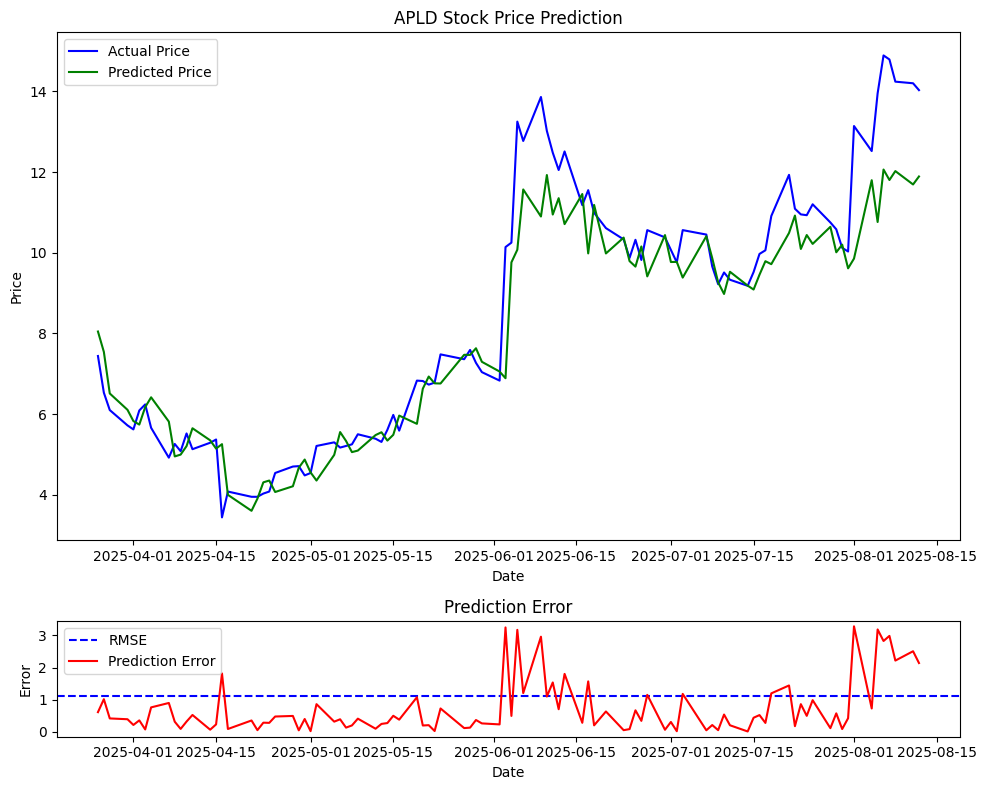

In [145]:
#visualization
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4,1)
axl = fig.add_subplot(gs[:3, 0])

axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
axl.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color ='blue', linestyle ='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

In [146]:
#conclusion: predicted prices were slightly accurate & close to actual price but delayed in date